<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-and-prepare-data-for-the-analysis" data-toc-modified-id="Download-and-prepare-data-for-the-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download and prepare data for the analysis</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data preparation</a></span></li></ul></li><li><span><a href="#Models'-calibration" data-toc-modified-id="Models'-calibration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models' calibration</a></span><ul class="toc-item"><li><span><a href="#Autoencoders" data-toc-modified-id="Autoencoders-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Autoencoders</a></span></li><li><span><a href="#Lee-Carter-model" data-toc-modified-id="Lee-Carter-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Lee-Carter model</a></span></li><li><span><a href="#Simulations-and-prediction" data-toc-modified-id="Simulations-and-prediction-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Simulations and prediction</a></span></li></ul></li></ul></div>

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import io
import os
os.environ['PYTHONHASHSEED']=str(1)

import requests
import pandas as pd
import numpy as np
import random

#statistical packages
from scipy.stats import stats\

#plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

#deep learning libraries
import tensorflow as tf
#from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model
from keras.optimizers import adam
from keras import layers

#LeeCarter module
from LC import LeeCarter

Using TensorFlow backend.


**Implementation based on the following paper**

Hainaut, D. (2018). A NEURAL-NETWORK ANALYZER FOR MORTALITY FORECAST. ASTIN Bulletin, 48(2), 481-508. doi:10.1017/asb.2017.45. Available at: https://www.cambridge.org/core/journals/astin-bulletin-journal-of-the-iaa/article/neuralnetwork-analyzer-for-mortality-forecast/9045C2A616EF9E9B063560704DC399AD. 


# Download and prepare data for the analysis

In [236]:
mort_total_fra = pd.read_csv('./data/dataFrenchPop.csv')
mort_total_fra.head()
mort_total_fra.columns = mort_total_fra.columns.astype(int)

In [237]:
#select data for the analysis
#French total population, years under investigation 1946 - 2014
columns = range(1946, 2015)
mort_raw = mort_total_fra.loc[:,columns]
mort_total_fra.index.name = "Age"

In [238]:
mort_raw.head()

,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Age,,,,,,,,,,,,,,,,,,,,,
0,0.08094,0.07111,0.05573,0.05968,0.05139,0.04942,0.04484,0.04126,0.04063,0.03817,...,0.00369,0.00380,0.00367,0.00372,0.00376,0.00359,0.00337,0.00345,0.00355,0.00342
1,0.00961,0.00731,0.00541,0.00648,0.00497,0.00556,0.00555,0.00419,0.00413,0.00414,...,0.00031,0.00033,0.00032,0.00031,0.00029,0.00029,0.00029,0.00027,0.00025,0.00027
2,0.00382,0.00283,0.00236,0.00233,0.00184,0.00182,0.00183,0.00176,0.00158,0.00142,...,0.00020,0.00020,0.00020,0.00018,0.00021,0.00017,0.00016,0.00017,0.00018,0.00016
3,0.00268,0.00189,0.00155,0.00160,0.00126,0.00130,0.00113,0.00103,0.00091,0.00097,...,0.00015,0.00015,0.00014,0.00017,0.00015,0.00013,0.00011,0.00014,0.00014,0.00011
4,0.00225,0.00142,0.00113,0.00114,0.00098,0.00094,0.00088,0.00085,0.00075,0.00073,...,0.00013,0.00012,0.00012,0.00012,0.00010,0.00009,0.00009,0.00011,0.00011,0.00009


In [239]:
mort_raw.tail()

,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Age,,,,,,,,,,,,,,,,,,,,,
105,0.50614,0.49386,0.47202,0.52330,0.50309,0.53051,0.51027,0.53460,0.50671,0.51036,...,0.45806,0.44599,0.44671,0.45252,0.45298,0.44965,0.44416,0.46241,0.45584,0.44123
106,0.51917,0.50724,0.48603,0.53563,0.51633,0.54272,0.52352,0.54678,0.52016,0.52374,...,0.47813,0.46657,0.46741,0.47322,0.47373,0.47062,0.46557,0.48334,0.47714,0.46309
107,0.53143,0.51989,0.49939,0.54715,0.52879,0.55407,0.53594,0.55807,0.53279,0.53628,...,0.49702,0.48604,0.48698,0.49272,0.49326,0.49039,0.48579,0.50292,0.49712,0.48375
108,0.54292,0.53181,0.51209,0.55786,0.54048,0.56459,0.54754,0.56850,0.54460,0.54797,...,0.51465,0.50431,0.50533,0.51094,0.51150,0.50887,0.50472,0.52107,0.51569,0.50308
109,0.55365,0.54300,0.52411,0.56780,0.55140,0.57429,0.55832,0.57809,0.55558,0.55884,...,0.53097,0.52132,0.52238,0.52782,0.52838,0.52600,0.52228,0.53774,0.53280,0.52101


In [240]:
mort_raw.shape

(110, 69)

## Data preparation

In [241]:
age_range = range(19, 109)
train_range = range(1975, 2001)
valid_range = range(2001, 2015)
total_range = range(1975, 2015)

mort_raw = mort_raw.loc[age_range, total_range].astype(float)

data_log = np.log(-np.log(1-mort_raw)) #calculate log-mortality
data_log.replace([np.inf, -np.inf], np.nan, inplace=True)
data_log.ffill(axis=1, inplace=True)
data_log.ffill(axis=0, inplace=True)

train_data_log = data_log.loc[:, train_range]
valid_data_log = data_log.loc[:, valid_range]

train_data_log_mean = train_data_log.mean(axis=1)

In [242]:
train_data_log.head(5)

,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
Age,,,,,,,,,,,,,,,,,,,,,
19,-6.644741,-6.692024,-6.660255,-6.758755,-6.708294,-6.692024,-6.741651,-6.750166,-6.811895,-6.917310,...,-7.058148,-7.105796,-7.093670,-7.168735,-7.222101,-7.235899,-7.195062,-7.307898,-7.278474,-7.264080
20,-6.700126,-6.644741,-6.724833,-6.683986,-6.676013,-6.652468,-6.716530,-6.708294,-6.750166,-6.802840,...,-6.937729,-7.093670,-7.012666,-7.105796,-7.143082,-7.235899,-7.278474,-7.235899,-7.155827,-7.293078
21,-6.733207,-6.668103,-6.660255,-6.741651,-6.683986,-6.668103,-6.708294,-6.724833,-6.716530,-6.750166,...,-6.969160,-6.969160,-6.927468,-6.948097,-7.081689,-7.130499,-7.143082,-7.143082,-7.208490,-7.278474
22,-6.821032,-6.692024,-6.733207,-6.811895,-6.741651,-6.708294,-6.750166,-6.724833,-6.750166,-6.758755,...,-6.887442,-6.937729,-6.917310,-7.012666,-7.012666,-7.035148,-7.168735,-7.093670,-7.181812,-7.278474
23,-6.839561,-6.776157,-6.811895,-6.848956,-6.802840,-6.784972,-6.830254,-6.811895,-6.750166,-6.784972,...,-6.877681,-6.907255,-7.023844,-6.990677,-7.058148,-7.118071,-7.143082,-7.181812,-7.118071,-7.264080


In [243]:
valid_data_log.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Age,,,,,,,,,,,,,,
19,-7.181812,-7.401747,-7.452192,-7.505317,-7.542368,-7.600652,-7.751510,-7.751510,-7.728516,-7.728516,-7.751510,-7.751510,-7.901823,-8.016253
20,-7.222101,-7.235899,-7.338213,-7.452192,-7.452192,-7.580845,-7.523671,-7.684054,-7.684054,-7.706038,-7.662543,-7.706038,-7.775046,-7.823846
21,-7.278474,-7.322941,-7.385481,-7.435093,-7.487294,-7.580845,-7.523671,-7.561422,-7.523671,-7.751510,-7.620860,-7.706038,-7.823846,-7.929226
22,-7.235899,-7.235899,-7.322941,-7.435093,-7.452192,-7.600652,-7.620860,-7.505317,-7.641484,-7.600652,-7.641484,-7.662543,-7.706038,-7.823846
23,-7.322941,-7.338213,-7.322941,-7.401747,-7.338213,-7.505317,-7.469589,-7.505317,-7.523671,-7.542368,-7.641484,-7.728516,-7.751510,-7.823846


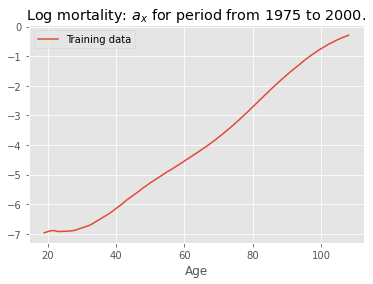

In [244]:
train_data_log_mean.plot(title=f'Log mortality: $a_x$ for period from {train_data_log.columns.min()} to {train_data_log.columns.max()}.', label='Training data')
plt.legend();

In [245]:
train_data_log_mean

Age
19    -6.971316
20    -6.928382
21    -6.895521
22    -6.893846
23    -6.921654
         ...   
104   -0.489171
105   -0.434629
106   -0.383931
107   -0.337001
108   -0.293727
Length: 90, dtype: float64

# Models' calibration

## Autoencoders

In [246]:
#remove randomness
def reset_seeds():
    os.environ['PYTHONHASHSEED'] = str(1)
    tf.random.set_random_seed(1)
    np.random.seed(1)
    random.seed(1)

In [247]:
#define loss function (root mean square error) as in the paper
def sse(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred))

In [248]:
#define activation function as in the paper
def tanh_sigmoid(x):
    return 2 / (1 + K.exp(-x)) - 1

In [249]:
#calculate deviations from the mean (per age and year)
X_t = train_data_log.sub(train_data_log_mean, axis=0).T
X_t_valid = valid_data_log.sub(train_data_log_mean, axis=0).T

In [250]:
reset_seeds()

input_dim = train_data_log.shape[0]
outer_dim = 5
inner_dim = 4

input_layer = Input(shape=(input_dim, ), name='input_layer')

x = Dense(outer_dim, activation=tanh_sigmoid, name='encoder_1')(input_layer)
encoded = Dense(inner_dim, activation='linear', name='encoder_2')(x)
x = Dense(outer_dim, activation=tanh_sigmoid, name='decoder_1')(encoded)
decoded = Dense(input_dim, activation='linear', name='decoder_2')(x)

reset_seeds()

#set up full model
autoencoder = Model(input_layer, decoded)

#set up encoder model
encoder = Model(input_layer, encoded)

#set up decoder function
encoded_input = Input(shape=(inner_dim,))
x = autoencoder.layers[-2](encoded_input)
decoded_layer = autoencoder.layers[-1](x)

decoder = Model(encoded_input, decoded_layer)

autoencoder.summary()
encoder.summary()
decoder.summary()

opt = adam(lr=0.002)

autoencoder.compile(optimizer=opt, loss=sse) #learning rate schedule (investigate - learning rate)
history = autoencoder.fit(X_t, X_t,
                            epochs=1000,
                            verbose=False,
                            validation_data=(X_t_valid, X_t_valid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 90)                0         
_________________________________________________________________
encoder_1 (Dense)            (None, 5)                 455       
_________________________________________________________________
encoder_2 (Dense)            (None, 4)                 24        
_________________________________________________________________
decoder_1 (Dense)            (None, 5)                 25        
_________________________________________________________________
decoder_2 (Dense)            (None, 90)                540       
Total params: 1,044
Trainable params: 1,044
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_la

<AxesSubplot:>

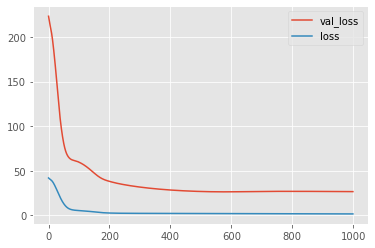

In [251]:
pd.DataFrame(history.history).plot()

In [252]:
k_nn = pd.DataFrame(encoder.predict(X_t))
def jb_test_ae(df):
    for c in df.columns:
        jb_stat, p_value = stats.jarque_bera(df[c].diff()[1:])
        print('--- JB for column %s ---' % c)
        print('JB test statistic equal to: %0.4f' % jb_stat)
        print('p-value equal to: %0.4f' % p_value)

#JB test for normality of differences in the development of latent factors
jb_test_ae(k_nn)

--- JB for column 0 ---
JB test statistic equal to: 1.0600
p-value equal to: 0.5886
--- JB for column 1 ---
JB test statistic equal to: 0.9218
p-value equal to: 0.6307
--- JB for column 2 ---
JB test statistic equal to: 1.4805
p-value equal to: 0.4770
--- JB for column 3 ---
JB test statistic equal to: 1.7166
p-value equal to: 0.4239


In [253]:
#check if encoder->decoder and autoencoder give the same results
np.allclose(decoder.predict(encoder.predict(X_t)), autoencoder.predict(X_t))

True

In [254]:
def calc_goodness_of_fit(act_mort, pred_mort):
    sum_se = (act_mort.sub(pred_mort)**2).sum().sum()
    avg_error = act_mort.sub(pred_mort).mean().mean()
    max_error = act_mort.sub(pred_mort).max().max()
    min_error = act_mort.sub(pred_mort).min().min()
    return sum_se, avg_error, max_error, min_error

In [255]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(X_t, autoencoder.predict(X_t))
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 1.66
Average error: -0.0000
Maximum error: 0.0986
Minimum error: -0.1223


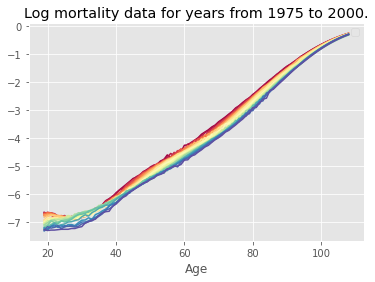

In [256]:
train_data_log.plot(colormap="Spectral")
plt.title('Log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

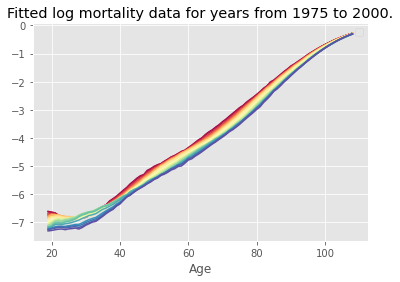

In [257]:
fitted_data_log = pd.DataFrame(autoencoder.predict(X_t).T, index=train_data_log.index, columns=train_data_log.columns)
fitted_data_log.add(train_data_log_mean, axis=0).plot(colormap="Spectral")
plt.title('Fitted log mortality data for years from {} to {}.'.format(train_data_log.columns.min(), train_data_log.columns.max()))
plt.legend('')
plt.show();

## Lee-Carter model

In [258]:
#LeeCarter model with one latent factor
lc_1 = LeeCarter(no_latent_factors=1)
lc_1.fit(train_data_log)

Model fitted.


In [259]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(lc_1.predict(train_data_log), train_data_log)
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 5.40
Average error: -0.0000
Maximum error: 0.2834
Minimum error: -0.2249


In [260]:
def jb_test_lc(model):
    diffs = model.kts.diff()[1:]
    for c in diffs.columns:
        jb_stat, p_value = stats.jarque_bera(diffs[c])
        print('JB test statistic is equal to: %0.4f' % (jb_stat))
        print('p-value equal to: %0.4f' % (p_value))
jb_test_lc(lc_1)

JB test statistic is equal to: 1.2548
p-value equal to: 0.5340


In [261]:
#LeeCarter model with two latent factors
lc_2 = LeeCarter(no_latent_factors=2)
lc_2.fit(train_data_log)

Model fitted.


In [262]:
sum_se, avg_error, max_error, min_error = calc_goodness_of_fit(lc_2.predict(train_data_log), train_data_log)
print('Sum of squared errors: %0.2f' % sum_se)
print('Average error: %0.4f' % avg_error)
print('Maximum error: %0.4f' % max_error)
print('Minimum error: %0.4f' % min_error)

Sum of squared errors: 2.26
Average error: -0.0000
Maximum error: 0.1321
Minimum error: -0.1048


In [263]:
jb_test_lc(lc_2)

JB test statistic is equal to: 1.2548
p-value equal to: 0.5340
JB test statistic is equal to: 6.8061
p-value equal to: 0.0333


## Simulations and prediction

In [264]:
#define some useful functions
def plot_kts(kts):
    """
    Helper function to plot the kappa parameters from 
    estimated Lee-Carter or Autoencoder mortality model.

    Parameters:
    -----------
    kts (pd.DataFrame) - Data Frame with kappa parameters in columns.

    Returns:
    --------
    none

    """
    if(len(kts.columns)==1):
        kts.plot()
        plt.legend("")
    else:
        fig, axs = plt.subplots(ncols=len(kts.columns), figsize=(14,5))    
        for i, c in enumerate(kts.columns):
            sns.lineplot(kts.index, kts.iloc[:,i], ax=axs[i]).set_title('$\kappa_{%i}$' %(i+1))
    plt.show()

def draw_simulations(kts, no_sims=1000, no_years=20):
    """
    Draw stochastic simulations and calculate mean over simulations for kappa parameters from 
    estimated Lee-Carter or Autoencoder mortality model.

    Parameters:
    -----------
    kts (pd.DataFrame) - Data Frame with kappa parameters in columns
    no_sims (int) - number of simulations to be drawn
    no_years (int) . number of future years to extrapolate

    Returns:
    --------
    kts (pd.DataFrame) - Data Frame with the projection of the mean of extrapolated kappa parameters

    """
    diffs = kts.iloc[-20:,:].diff()[1:].describe()
    simulations = {}

    mean_simulations = {}
    for c in diffs.columns:
        mu = diffs[c].loc['mean']
        sigma = diffs[c].loc['std']
        simulations[c] = np.random.normal(mu, sigma, (no_sims, no_years))

    for i in simulations.keys():
        mean_simulations[i] = simulations[i].mean(axis=0)

    simulations_kts = pd.DataFrame(mean_simulations, index=range(kts.index.max() + 1, kts.index.max() + 1 + no_years))
    simulations_kts.index.name = 'Year'

    diffs_cum = kts.iloc[[0]].append(kts.diff()[1:].append(simulations_kts))
    diffs_cum = diffs_cum.cumsum()

    return diffs_cum

def draw_det_simulations(kts, lookback_period=20, no_years=20):
    """
    Extrapolate (deterministically via simple regression) kappa parameters for  
    estimated Lee-Carter or Autoencoder mortality model.

    Parameters:
    -----------
    kts (pd.DataFrame) - Data Frame with kappa parameters in columns
    lookback_period (int) - length of a lookback period to base the estimation
    no_years (int) . number of future years to extrapolate

    Returns:
    --------
    kts (pd.DataFrame) - Data Frame with extrapolated kappa parameters

    """
    idx = kts.index.max()
    diffs = kts.iloc[-lookback_period:,:].diff()[1:].mean()
    diffs = pd.DataFrame(diffs)
    print(diffs)
    for i in range(no_years):
        kts = kts.append(kts.iloc[-1,:].add(diffs.T))
    kts.index = range(idx+no_years+1)
    return kts

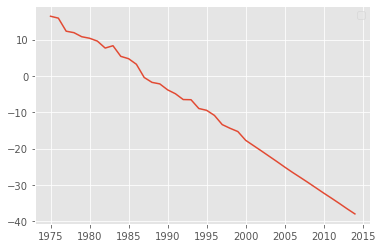

In [265]:
#simulate future kts for Lee-Carter with one factor
kt_lc1 = lc_1.kts
sims_lc1 = draw_simulations(kt_lc1, no_sims=1000, no_years=14)
plot_kts(sims_lc1)

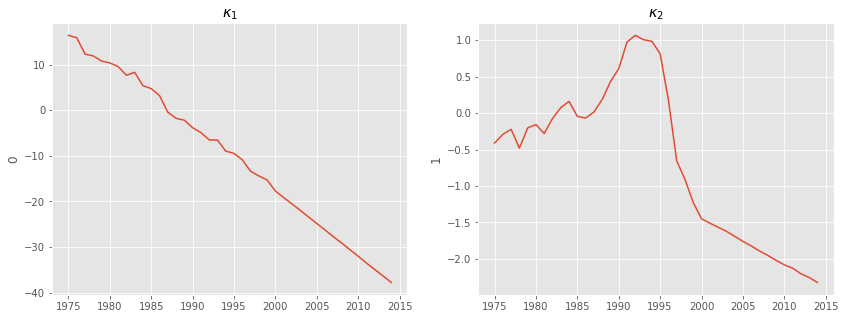

In [266]:
#simulate future kts for Lee-Carter with two factors
kt_lc2 = lc_2.kts
sims_lc2 = draw_simulations(kt_lc2, no_sims=1000, no_years=14)
plot_kts(sims_lc2)

          0
0 -0.239190
1  0.010067
2  0.081207
3 -0.008675


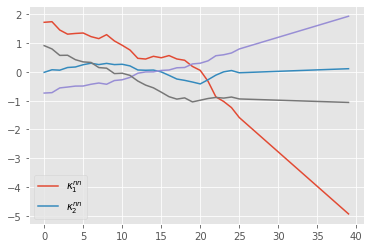

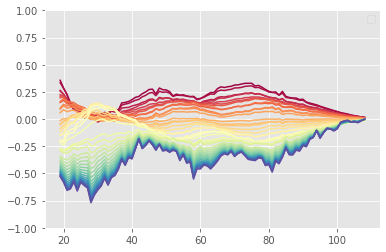

In [267]:
#simulate future kts for Autoencoders with two latent factors
k_nn = pd.DataFrame(encoder.predict(X_t))
k_nn_sim = draw_det_simulations(k_nn, lookback_period=10, no_years=14)
k_nn_sim.plot()
plt.legend(['$\kappa_1^{nn}$', '$\kappa_2^{nn}$'])
plt.show();

X_tmp = decoder.predict(k_nn_sim.iloc[-40:,:])
X_pred = pd.DataFrame(X_tmp.T, index = range(19, 109))
X_pred.columns = range(1975, 1975+40)
X_pred.plot(colormap='Spectral')
plt.ylim([-1,1])
plt.legend('')
plt.show();

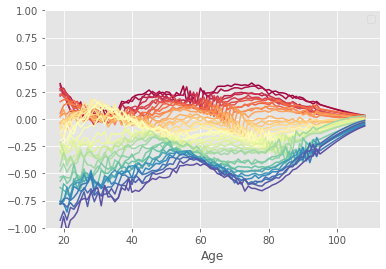

In [268]:
data_log.sub(train_data_log_mean, axis=0).plot(colormap="Spectral")
plt.legend('')
plt.ylim([-1.25,1.25])
plt.ylim([-1,1])
plt.show()

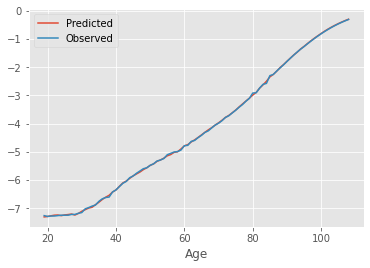

In [269]:
#check model fit for in sample years (e.g. 1975, 1985, 1995, 2000)
years = 2000

df_1 = X_pred.add(train_data_log_mean, axis=0)
df_2 = data_log
df_1.loc[:, years].plot()
df_2.loc[:, years].plot()
plt.legend(['Predicted', 'Observed'])
plt.show()

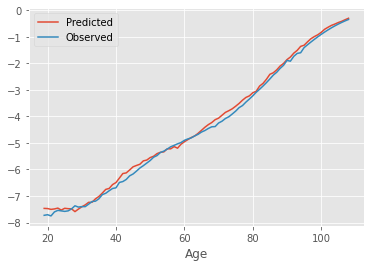

In [270]:
#check model fit for out of sample years (e.g. 2005, 2010, 2014)
years = 2010

df_1 = X_pred.add(train_data_log_mean, axis=0)
df_2 = data_log
df_1.loc[:, years].plot()
df_2.loc[:, years].plot()
plt.legend(['Predicted', 'Observed'])
plt.show()